In [ ]:
# 0) SETUP & DATA
import math, random, time, os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# --- CIFAR-10: 32x32 color images (10 classes) ---
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914,0.4822,0.4465), std=(0.2470,0.2435,0.2616)),
])

trainset_full = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset      = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Use a subset to keep demos fast & reproducible
N_TRAIN = 10000
idxs = np.random.permutation(len(trainset_full))[:N_TRAIN]
trainset = Subset(trainset_full, idxs)

BATCH = 128
train_loader = DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(testset,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

print("Device:", DEVICE, "| Train batches:", len(train_loader))


100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Device: cuda | Train batches: 79


Utility: hooks & tracking

In [ ]:
# 1) UTILS: tracking grad norms & activation saturation

def grad_norms_per_layer(model):
    norms = []
    for name, p in model.named_parameters():
        if p.grad is None: continue
        norms.append((name, p.grad.detach().norm().item()))
    return norms

class ActivationTracker:
    """
    Tracks activation saturation for tanh/sigmoid/ReLU layers.
    For tanh: saturated if |a| > 0.95
    For sigmoid: saturated if a < 0.05 or a > 0.95
    For ReLU: dead if a == 0 (proxy for "inactive")
    """
    def __init__(self):
        self.records = []  # list of dicts: {"layer": name, "sat_ratio": float}
        self._handles = []
    def attach(self, model):
        for name, m in model.named_modules():
            if isinstance(m, (nn.Tanh, nn.Sigmoid, nn.ReLU)):
                self._handles.append(m.register_forward_hook(self._hook(name)))
    def _hook(self, name):
        def fn(module, inp, out):
            with torch.no_grad():
                a = out.detach()
                if isinstance(module, nn.Tanh):
                    sat = (a.abs() > 0.95).float().mean().item()
                elif isinstance(module, nn.Sigmoid):
                    sat = ((a < 0.05) | (a > 0.95)).float().mean().item()
                else:  # ReLU
                    sat = (a == 0).float().mean().item()
                self.records.append({"layer": name, "sat_ratio": sat})
        return fn
    def clear(self): self.records.clear()
    def close(self):
        for h in self._handles: h.remove()
        self._handles.clear()

def plot_grad_heatmap(grad_logs, title):
    """
    grad_logs: list over steps of list[(name, norm)]
    builds a matrix [num_layers x steps] of log10(grad_norm + eps)
    """
    # extract consistent ordering of params
    names = [n for (n, _) in grad_logs[0]]
    mat = np.array([[v for (_, v) in row] for row in grad_logs]).T  # [L x T]
    plt.figure(figsize=(8, 4.8))
    plt.imshow(np.log10(mat + 1e-12), aspect='auto', origin='lower')
    plt.colorbar(label='log10(grad norm)')
    plt.yticks(range(len(names)), [n.replace(".weight","") for n in names], fontsize=8)
    plt.xlabel("Training step"); plt.ylabel("Layer")
    plt.title(title)
    plt.tight_layout(); plt.show()

def plot_saturation(sat_records, title):
    # Aggregate by layer (average across steps)
    by_layer = {}
    for rec in sat_records:
        by_layer.setdefault(rec["layer"], []).append(rec["sat_ratio"])
    layers, vals = [], []
    for k, v in by_layer.items():
        layers.append(k); vals.append(float(np.mean(v)))
    order = np.argsort(vals)
    layers = [layers[i] for i in order]
    vals   = [vals[i] for i in order]
    plt.figure(figsize=(8, 3.8))
    plt.barh(layers, vals)
    plt.xlabel("Saturation ratio"); plt.title(title)
    plt.tight_layout(); plt.show()


Vanishing Gradients on CIFAR-10 (Deep MLP + Tanh + Small Init)

Done. Steps: 120


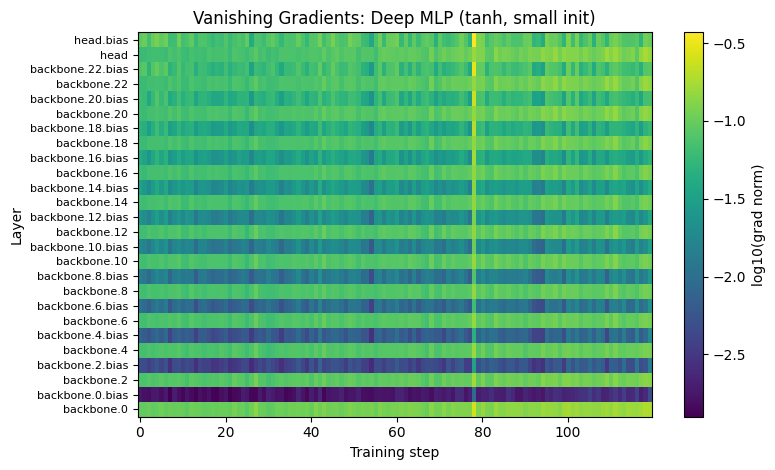

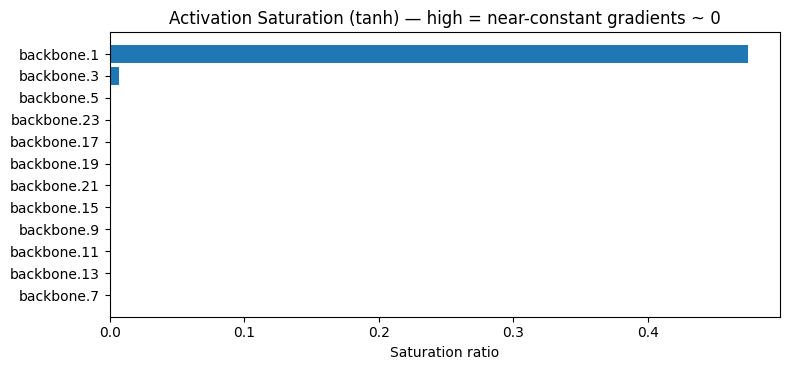

In [ ]:
# 2) VANISHING: deep MLP (tanh, small init) on CIFAR-10

class DeepMLP_Tanh(nn.Module):
    def __init__(self, depth=12, width=256, weight_scale=0.05):
        super().__init__()
        layers = []
        in_dim = 3*32*32
        for _ in range(depth):
            lin = nn.Linear(in_dim, width)
            nn.init.normal_(lin.weight, mean=0.0, std=weight_scale)
            nn.init.zeros_(lin.bias)
            layers += [lin, nn.Tanh()]
            in_dim = width
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, 10)
        nn.init.normal_(self.head.weight, mean=0.0, std=weight_scale)
        nn.init.zeros_(self.head.bias)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.backbone(x)
        return self.head(x)

model = DeepMLP_Tanh(depth=12, width=256, weight_scale=0.05).to(DEVICE)
opt    = optim.SGD(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()

tracker = ActivationTracker(); tracker.attach(model)
grad_logs = []
steps = 120

model.train()
data_iter = iter(train_loader)
for t in range(steps):
    try:
        xb, yb = next(data_iter)
    except StopIteration:
        data_iter = iter(train_loader)
        xb, yb = next(data_iter)
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
    opt.zero_grad(set_to_none=True)
    logits = model(xb)
    loss = criterion(logits, yb)
    loss.backward()
    grad_logs.append(grad_norms_per_layer(model))
    opt.step()

print("Done. Steps:", steps)
plot_grad_heatmap(grad_logs, "Vanishing Gradients: Deep MLP (tanh, small init)")
plot_saturation(tracker.records, "Activation Saturation (tanh) — high = near-constant gradients ~ 0")
tracker.close()


Exploding Gradients on CIFAR-10 (Deep MLP + ReLU + Large Init)

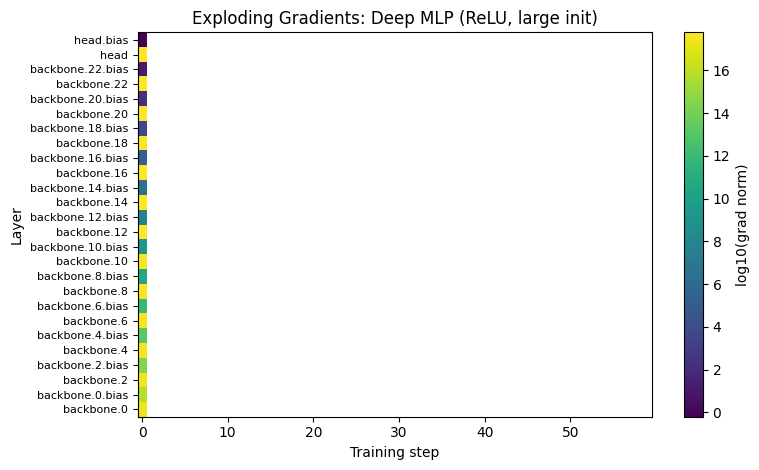

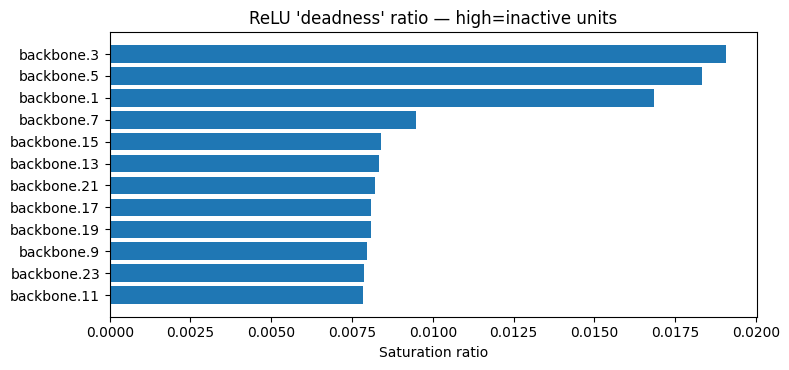

In [ ]:
# 3) EXPLODING: deep MLP (ReLU, large init)

class DeepMLP_ReLU(nn.Module):
    def __init__(self, depth=12, width=256, weight_scale=2.0):
        super().__init__()
        layers = []
        in_dim = 3*32*32
        for _ in range(depth):
            lin = nn.Linear(in_dim, width)
            nn.init.normal_(lin.weight, mean=0.0, std=weight_scale)  # LARGE
            nn.init.zeros_(lin.bias)
            layers += [lin, nn.ReLU(inplace=True)]
            in_dim = width
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, 10)
        nn.init.normal_(self.head.weight, mean=0.0, std=weight_scale)
        nn.init.zeros_(self.head.bias)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.backbone(x)
        return self.head(x)

model = DeepMLP_ReLU(depth=12, width=256, weight_scale=2.0).to(DEVICE)
opt    = optim.SGD(model.parameters(), lr=1e-4)  # tiny lr to observe explosion without instant NaN
criterion = nn.CrossEntropyLoss()

tracker = ActivationTracker(); tracker.attach(model)
grad_logs = []
steps = 60

model.train()
data_iter = iter(train_loader)
for t in range(steps):
    try:
        xb, yb = next(data_iter)
    except StopIteration:
        data_iter = iter(train_loader); xb, yb = next(data_iter)
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
    opt.zero_grad(set_to_none=True)
    logits = model(xb)
    loss = criterion(logits, yb)
    loss.backward()
    grad_logs.append(grad_norms_per_layer(model))
    # (Optional) try gradient clipping to stabilize:
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    opt.step()

plot_grad_heatmap(grad_logs, "Exploding Gradients: Deep MLP (ReLU, large init)")
plot_saturation(tracker.records, "ReLU 'deadness' ratio — high=inactive units")
tracker.close()


LEARNING-RATE SENSITIVITY on a small CNN

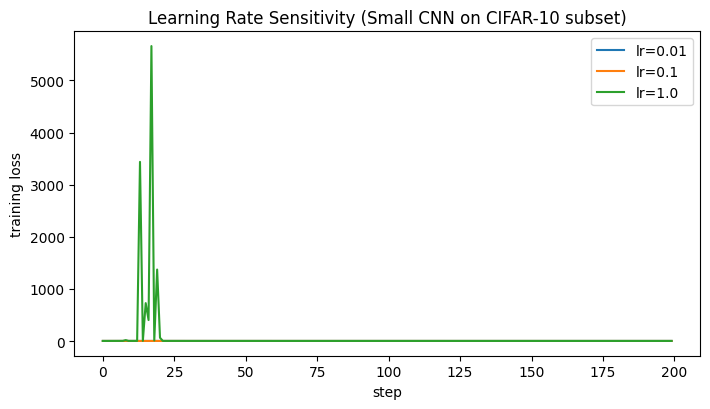

In [ ]:
# 4) LEARNING-RATE SENSITIVITY on a small CNN

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
            nn.Flatten(),
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, 10),
        )
    def forward(self, x): return self.net(x)

def train_for_steps(model, lr, steps=200):
    model = model.to(DEVICE)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.0)
    crit = nn.CrossEntropyLoss()
    losses = []
    data_iter = iter(train_loader)
    model.train()
    for t in range(steps):
        try: xb, yb = next(data_iter)
        except StopIteration:
            data_iter = iter(train_loader); xb, yb = next(data_iter)
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return losses

lrs = [0.01, 0.1, 1.0]  # small, good-ish, too large
curves = {}
for lr in lrs:
    curves[lr] = train_for_steps(SmallCNN(), lr=lr, steps=200)

plt.figure(figsize=(7.2, 4.2))
for lr, losses in curves.items():
    plt.plot(losses, label=f"lr={lr}")
plt.xlabel("step"); plt.ylabel("training loss")
plt.title("Learning Rate Sensitivity (Small CNN on CIFAR-10 subset)")
plt.legend(); plt.tight_layout(); plt.show()


2D Loss-Landscape Slice (Small CNN)

KeyboardInterrupt: 

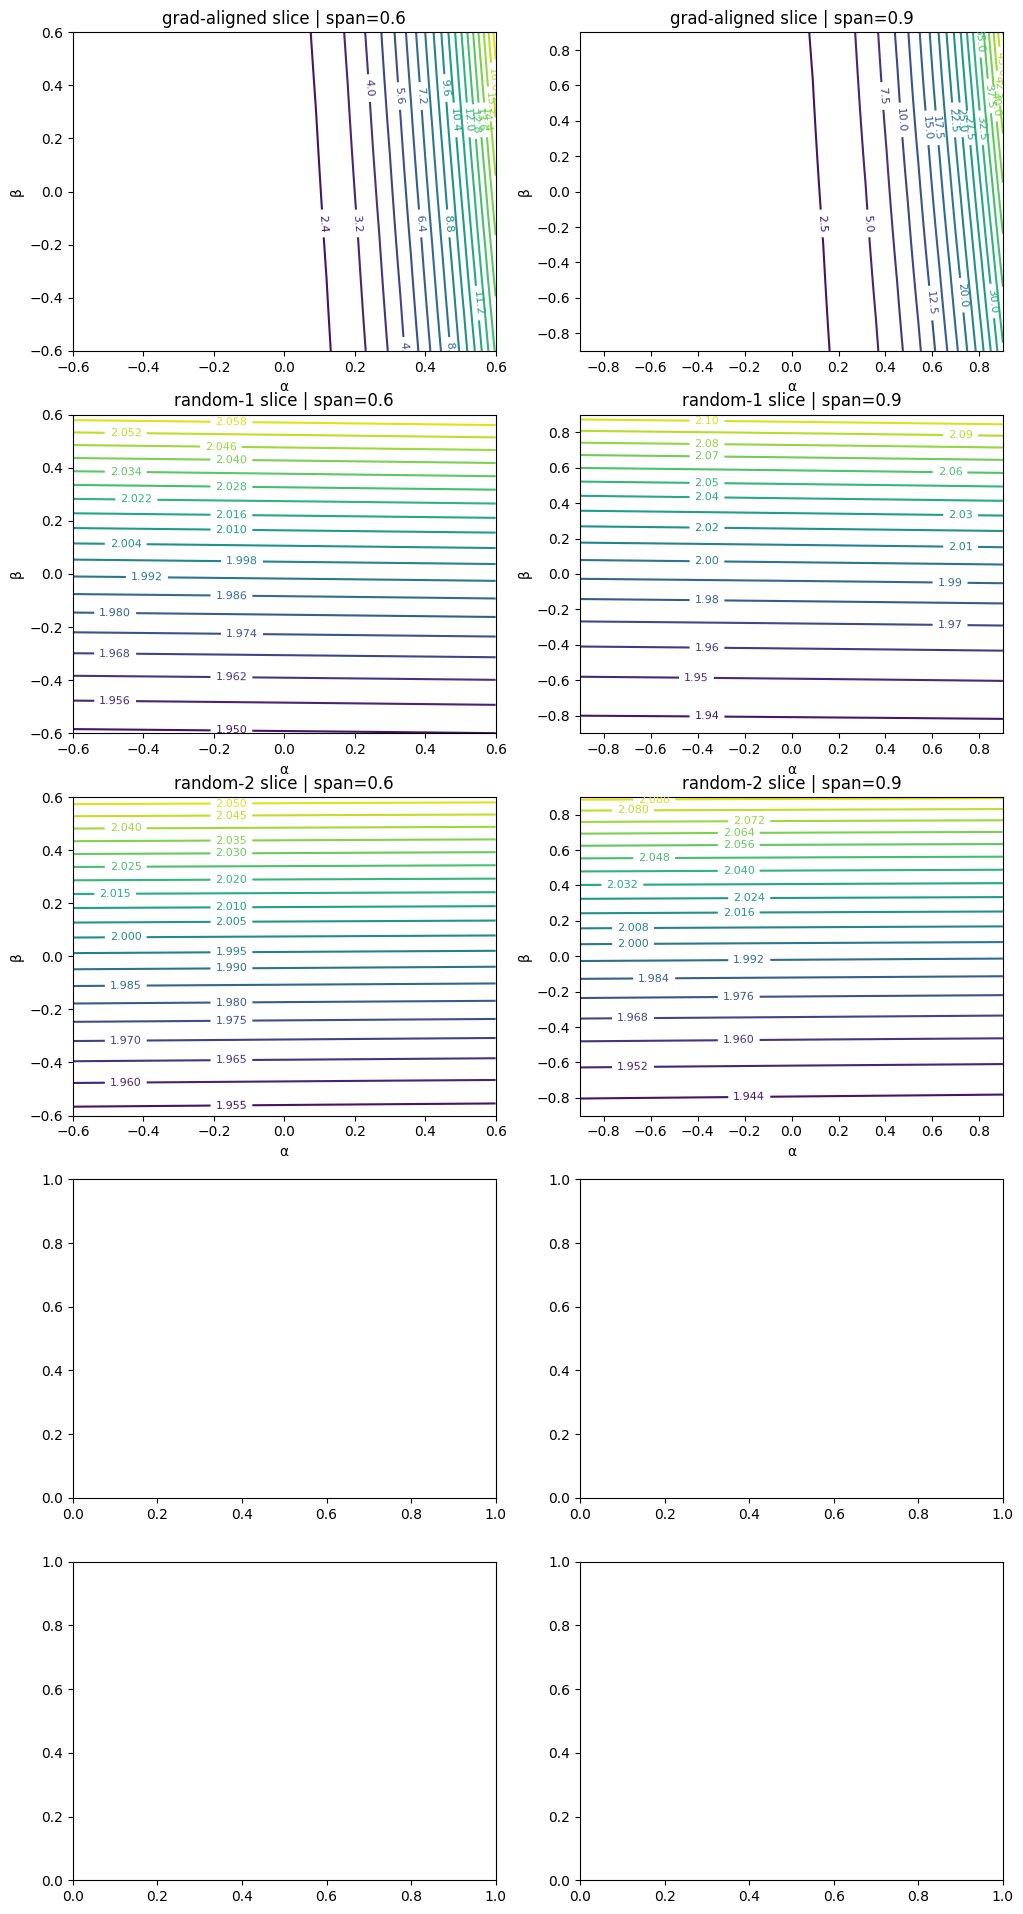

In [ ]:
# 5) 2D LOSS-LANDSCAPE EXPLORER — multiple slices + gradient-aligned directions

import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# --- helpers (same as before) ---
def extract_params_vector(model):
    return torch.cat([p.detach().flatten() for p in model.parameters() if p.requires_grad])

def inject_params_vector_(model, vec):
    idx = 0
    for p in model.parameters():
        if not p.requires_grad:
            continue
        num = p.numel()
        p.data.copy_(vec[idx:idx+num].view_as(p))
        idx += num

def random_unit_like(vec):
    g = torch.randn_like(vec)
    return g / (g.norm() + 1e-12)

def gram_schmidt(u, v):
    # make v orthonormal to u
    u = u / (u.norm() + 1e-12)
    v = v - (u * (v @ u)).sum()  # project out u (works for 1D tensors as well)
    v = v / (v.norm() + 1e-12)
    return u, v

# --- (re)train a bit to get a meaningful point (unchanged) ---
model = SmallCNN().to(DEVICE)
opt   = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
crit  = nn.CrossEntropyLoss()
model.train()
data_iter = iter(train_loader)
for _ in range(100):
    try: xb, yb = next(data_iter)
    except StopIteration:
        data_iter = iter(train_loader); xb, yb = next(data_iter)
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
    opt.zero_grad(set_to_none=True)
    logits = model(xb); loss = crit(logits, yb)
    loss.backward(); opt.step()

# --- fixed mini-batches to optionally average loss over K batches (denoise) ---
def take_k_batches(data_loader, k=1):
    batches = []
    it = iter(data_loader)
    for _ in range(k):
        try:
            xb, yb = next(it)
        except StopIteration:
            it = iter(data_loader)
            xb, yb = next(it)
        batches.append((xb.to(DEVICE), yb.to(DEVICE)))
    return batches

fixed_batches = take_k_batches(train_loader, k=3)  # average over 3 minibatches to reduce noise

def avg_loss_at_params(vec):
    inject_params_vector_(model, vec)
    model.eval()
    with torch.no_grad():
        losses = []
        for xb, yb in fixed_batches:
            logits = model(xb)
            losses.append(crit(logits, yb).item())
    return float(np.mean(losses))

# base point and gradient direction
w0 = extract_params_vector(model).clone().detach()
model.zero_grad(set_to_none=True)
# compute grad at w0
inject_params_vector_(model, w0)
xb_g, yb_g = fixed_batches[0]
logits = model(xb_g); loss = crit(logits, yb_g)
loss.backward()
g = torch.cat([p.grad.detach().flatten() for p in model.parameters() if p.requires_grad])
g = g / (g.norm() + 1e-12)  # unit gradient direction

# --- utilities for slicing / scanning ---
def make_slice(d1, d2, span=0.5, grid=41):
    alphas = torch.linspace(-span, span, grid)
    betas  = torch.linspace(-span, span, grid)
    Z = np.zeros((grid, grid), dtype=np.float64)
    with torch.no_grad():
        for i, a in enumerate(alphas):
            for j, b in enumerate(betas):
                vec = w0 + a*d1 + b*d2
                Z[j, i] = avg_loss_at_params(vec)
    A, B = np.meshgrid(alphas.cpu().numpy(), betas.cpu().numpy())
    # restore base weights
    inject_params_vector_(model, w0)
    return A, B, Z

def one_d_scan(d, span=0.6, pts=201):
    """Scan the loss along a single direction d, return alphas and losses."""
    alphas = torch.linspace(-span, span, pts)
    Ls = []
    with torch.no_grad():
        for a in alphas:
            vec = w0 + a*d
            Ls.append(avg_loss_at_params(vec))
    inject_params_vector_(model, w0)
    return alphas.cpu().numpy(), np.array(Ls)

def count_turning_points(y):
    """Rudimentary non-convexity flag: counts local extrema along a 1D scan."""
    # finite-diff derivative sign changes
    dy = np.diff(y)
    signs = np.sign(dy + 1e-12)
    flips = np.sum((signs[1:] * signs[:-1]) < 0)
    return int(flips)

def params_list(model):
    return [p for p in model.parameters() if p.requires_grad]

def pack_list_to_vec(tensors):
    return torch.cat([t.flatten() for t in tensors])

def unpack_vec_to_list(vec, like_params):
    out = []
    idx = 0
    for p in like_params:
        n = p.numel()
        out.append(vec[idx:idx+n].view_as(p))
        idx += n
    return out


import torch.autograd as autograd

@torch.enable_grad()
def hvp(model, crit, xb, yb, vec):
    """
    Returns H @ vec where H is the Hessian of loss w.r.t. model params.
    Uses a single (xb, yb) mini-batch to keep it lightweight.
    """
    model.zero_grad(set_to_none=True)
    params = params_list(model)

    logits = model(xb)
    loss   = crit(logits, yb)

    # First gradient (create graph so we can differentiate again)
    grads1 = autograd.grad(loss, params, create_graph=True, retain_graph=True)
    flat_g = pack_list_to_vec(grads1)

    # Dot with 'vec' to get a scalar; then grad again -> HVP
    gv = (flat_g * vec).sum()
    grads2 = autograd.grad(gv, params, retain_graph=False)
    Hv = pack_list_to_vec(grads2).detach()

    return Hv


def power_iteration_top_eigvec(model, crit, xb, yb, iters=30):
    # start from random vector with unit norm
    pvec = extract_params_vector(model).detach()
    v = random_unit_like(pvec)

    for _ in range(iters):
        Hv = hvp(model, crit, xb, yb, v)
        v = Hv / (Hv.norm() + 1e-12)  # normalize

    # Rayleigh quotient (approx eigenvalue)
    lam = float((v @ hvp(model, crit, xb, yb, v)) / (v.norm()**2 + 1e-12))
    return v, lam

def orthonormalize(u, v):
    u = u / (u.norm() + 1e-12)
    v = v - (u * (v @ u))
    v = v / (v.norm() + 1e-12)
    return u, v

def top2_eigvecs_via_deflation(model, crit, xb, yb, iters=30):
    v1, lam1 = power_iteration_top_eigvec(model, crit, xb, yb, iters=iters)
    # project out v1 and run power iteration again
    pvec = extract_params_vector(model).detach()
    v2 = random_unit_like(pvec)
    v1, v2 = orthonormalize(v1, v2)

    for _ in range(iters):
        Hv = hvp(model, crit, xb, yb, v2)
        # deflate H along v1: (I - v1 v1^T) H (I - v1 v1^T) v2  ≈ Hv - v1 (v1^T Hv)
        Hv_orth = Hv - v1 * (v1 @ Hv)
        v2 = Hv_orth / (Hv_orth.norm() + 1e-12)

    lam2 = float((v2 @ hvp(model, crit, xb, yb, v2)) / (v2.norm()**2 + 1e-12))
    # ensure orthonormality
    v1, v2 = orthonormalize(v1, v2)
    return (v1, lam1), (v2, lam2)

# --- explore multiple slices ---
num_slices     = 4           # how many random slices to visualize
use_grad_slice = True        # include one slice aligned with gradient
span_list      = [0.6, 0.9]  # try two spans per slice
grid           = 41

slices = []

if use_grad_slice:
    # gradient-aligned + random orthogonal
    d1 = g.clone()
    d2 = random_unit_like(w0)
    d1, d2 = gram_schmidt(d1, d2)
    slices.append(("grad-aligned", d1, d2))

# random slices
for i in range(num_slices):
    d1 = random_unit_like(w0)
    d2 = random_unit_like(w0)
    d1, d2 = gram_schmidt(d1, d2)
    slices.append((f"random-{i+1}", d1, d2))

# plot slices with two spans each
nrows = len(slices)
ncols = len(span_list)
fig, axes = plt.subplots(nrows, ncols, figsize=(6.0*ncols, 4.8*nrows))
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1 or ncols == 1:
    axes = np.atleast_2d(axes)

for r, (label, d1, d2) in enumerate(slices):
    for c, span in enumerate(span_list):
        A, B, Z = make_slice(d1, d2, span=span, grid=grid)
        ax = axes[r, c]
        CS = ax.contour(A, B, Z, levels=20)
        ax.clabel(CS, inline=True, fontsize=8)
        ax.set_title(f"{label} slice | span={span}")
        ax.set_xlabel("α"); ax.set_ylabel("β")

plt.suptitle("2D Loss-Landscape Explorer (Small CNN, averaged over 3 mini-batches)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# --- 1D line scans to auto-flag likely non-convex regions ---
scan_dirs = []
# along each slice's d1 and d2
for (label, d1, d2) in slices:
    scan_dirs.append((f"{label} / d1", d1))
    scan_dirs.append((f"{label} / d2", d2))
# also along gradient and a random orthogonal to it
scan_dirs.append(("pure-gradient", g))
rnd = random_unit_like(w0)
_, rnd = gram_schmidt(g.clone(), rnd)
scan_dirs.append(("orthogonal-to-grad", rnd))

rows = math.ceil(len(scan_dirs)/2)
fig, axes = plt.subplots(rows, 2, figsize=(12, 3.2*rows))
axes = axes.flatten()

for i, (name, d) in enumerate(scan_dirs):
    a, Ls = one_d_scan(d, span=0.8, pts=301)
    flips = count_turning_points(Ls)
    axes[i].plot(a, Ls, linewidth=1.5)
    axes[i].set_title(f"{name} | turning points: {flips}")
    axes[i].set_xlabel("α"); axes[i].set_ylabel("loss")
    # Heuristic highlight: >1 turning point → likely non-convex along this direction
    if flips > 1:
        axes[i].axhspan(min(Ls), max(Ls), color='orange', alpha=0.08, label="likely non-convex")
        axes[i].legend()

plt.suptitle("1D Line Scans (turning-points heuristic for non-convexity)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# pick a fixed batch for HVP (curvature is local, so 1 batch is OK)
xb_h, yb_h = next(iter(train_loader))
xb_h = xb_h.to(DEVICE); yb_h = yb_h.to(DEVICE)

# get top-2 Hessian eigenvectors
(v1, lam1), (v2, lam2) = top2_eigvecs_via_deflation(model, crit, xb_h, yb_h, iters=30)
print(f"approx top eigenvalues: λ1≈{lam1:.3f}, λ2≈{lam2:.3f}")


# 2D slices along curvature directions
A, B, Z = make_slice(v1, v2, span=0.6, grid=61)
plt.figure(figsize=(7, 6))
CS = plt.contour(A, B, Z, levels=25)
plt.clabel(CS, inline=True, fontsize=8)
plt.title("Slice along top Hessian eigenvectors (span=0.6)")
plt.xlabel("α (v1)"); plt.ylabel("β (v2)")
plt.tight_layout(); plt.show()

# 1D scans
alphas, L1 = one_d_scan(v1, span=0.8, pts=301)
_,      L2 = one_d_scan(v2, span=0.8, pts=301)

plt.figure(figsize=(7.5, 3.8))
plt.plot(alphas, L1, label="along v1 (top curvature)")
plt.plot(alphas, L2, label="along v2 (2nd curvature)")
plt.xlabel("α"); plt.ylabel("loss"); plt.title("1D scans along Hessian eigenvectors")
plt.legend(); plt.tight_layout(); plt.show()


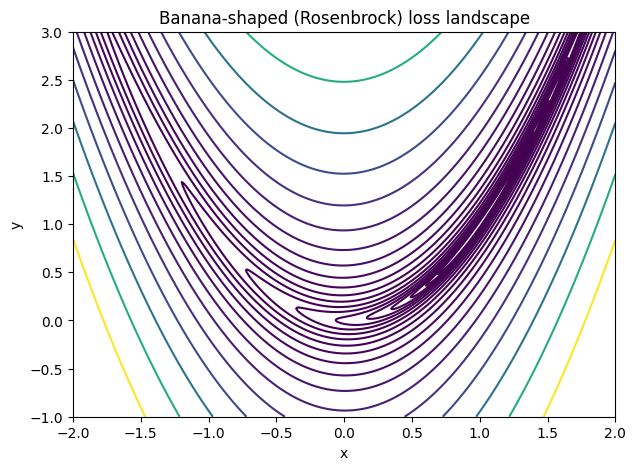

In [ ]:
# pip install matplotlib numpy
import numpy as np
import matplotlib.pyplot as plt

def rosenbrock(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2  # banana valley

# mesh grid
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = rosenbrock(X, Y)

plt.figure(figsize=(7,5))
plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
plt.title("Banana-shaped (Rosenbrock) loss landscape")
plt.xlabel('x'); plt.ylabel('y')
plt.show()


In [ ]:
def grad_rosenbrock(x, y):
    dx = -2*(1 - x) - 400*x*(y - x**2)
    dy = 200*(y - x**2)
    return np.array([dx, dy])

def gradient_descent(xy0, lr=0.001, steps=2000):
    xy = np.array(xy0, dtype=float)
    traj = [xy.copy()]
    for _ in range(steps):
        xy -= lr * grad_rosenbrock(*xy)
        traj.append(xy.copy())
    return np.array(traj)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Rosenbrock function (banana-shaped non-convex)
def f(x, y):
    return (1 - x)**2 + 100*(y - x**2)**2

def grad_f(x, y):
    dfdx = -2*(1 - x) - 400*x*(y - x**2)
    dfdy = 200*(y - x**2)
    return np.array([dfdx, dfdy])

# Generate surface grid
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


In [ ]:
def GD(xy0, lr=0.001, steps=2000):
    xy = np.array(xy0, dtype=float)
    traj = [xy.copy()]
    for _ in range(steps):
        g = grad_f(*xy)
        xy -= lr * g
        traj.append(xy.copy())
    return np.array(traj)


In [ ]:
def Momentum(xy0, lr=0.001, beta=0.9, steps=2000):
    xy = np.array(xy0, dtype=float)
    v = np.zeros_like(xy)
    traj = [xy.copy()]
    for _ in range(steps):
        g = grad_f(*xy)
        v = beta * v + (1 - beta) * g
        xy -= lr * v
        traj.append(xy.copy())
    return np.array(traj)


In [ ]:
def RMSProp(xy0, lr=0.001, beta=0.9, eps=1e-8, steps=2000):
    xy = np.array(xy0, dtype=float)
    Eg2 = np.zeros_like(xy)
    traj = [xy.copy()]
    for _ in range(steps):
        g = grad_f(*xy)
        Eg2 = beta * Eg2 + (1 - beta) * (g**2)
        xy -= lr * g / (np.sqrt(Eg2) + eps)
        traj.append(xy.copy())
    return np.array(traj)


In [ ]:
def Adam(xy0, lr=0.002, b1=0.9, b2=0.999, eps=1e-8, steps=2000):
    xy = np.array(xy0, dtype=float)
    m = np.zeros_like(xy)
    v = np.zeros_like(xy)
    traj = [xy.copy()]

    for t in range(1, steps+1):
        g = grad_f(*xy)

        m = b1*m + (1 - b1)*g
        v = b2*v + (1 - b2)*(g**2)

        m_hat = m / (1 - b1**t)
        v_hat = v / (1 - b2**t)

        xy -= lr * m_hat / (np.sqrt(v_hat) + eps)
        traj.append(xy.copy())

    return np.array(traj)


In [ ]:
def plot_trajectory(path, title):
    plt.figure(figsize=(8,6))
    plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 20), cmap='viridis')
    plt.plot(path[:,0], path[:,1], 'r-', linewidth=2)
    plt.scatter(path[0,0], path[0,1], color='blue', label="start")
    plt.scatter(path[-1,0], path[-1,1], color='red', label="end")
    plt.title(title, fontsize=16)
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_zoomed_trajectory(path, title, zoom=0.15):
    """
    Zoomed view with softened / blurred background contours so that
    the optimizer trajectory is visually dominant.
    """
    # Determine bounding box around the trajectory
    min_x, max_x = np.min(path[:,0]), np.max(path[:,0])
    min_y, max_y = np.min(path[:,1]), np.max(path[:,1])

    dx = max_x - min_x
    dy = max_y - min_y

    # Expand slightly beyond path bounding box
    x_lo = min_x - zoom*dx
    x_hi = max_x + zoom*dx
    y_lo = min_y - zoom*dy
    y_hi = max_y + zoom*dy

    # High-resolution grid in zoomed region
    x = np.linspace(x_lo, x_hi, 500)
    y = np.linspace(y_lo, y_hi, 500)
    Xz, Yz = np.meshgrid(x, y)
    Zz = f(Xz, Yz)

    # ---- Plot section ----
    plt.figure(figsize=(7.4, 5.6))

    # "Blurred" / softer contours
    plt.contour(
        Xz, Yz, Zz,
        levels=np.logspace(-2, 2, 15),  # fewer lines
        cmap='Greys',                   # very soft grayscale
        alpha=0.35,                     # translucent / blurred
        linewidths=1.0
    )

    # White outline to make the red trajectory pop
    plt.plot(path[:,0], path[:,1], color='white', linewidth=3.5, alpha=1.0)

    # Bold red foreground path
    plt.plot(path[:,0], path[:,1], color='red', linewidth=2.2, alpha=1.0)

    # Mark start and end points
    plt.scatter(path[0,0], path[0,1], color='blue', s=50, label="start")
    plt.scatter(path[-1,0], path[-1,1], color='red', s=50, label="end")

    plt.title(title + " (Zoomed & Highlighted)", fontsize=14)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()
    plt.show()


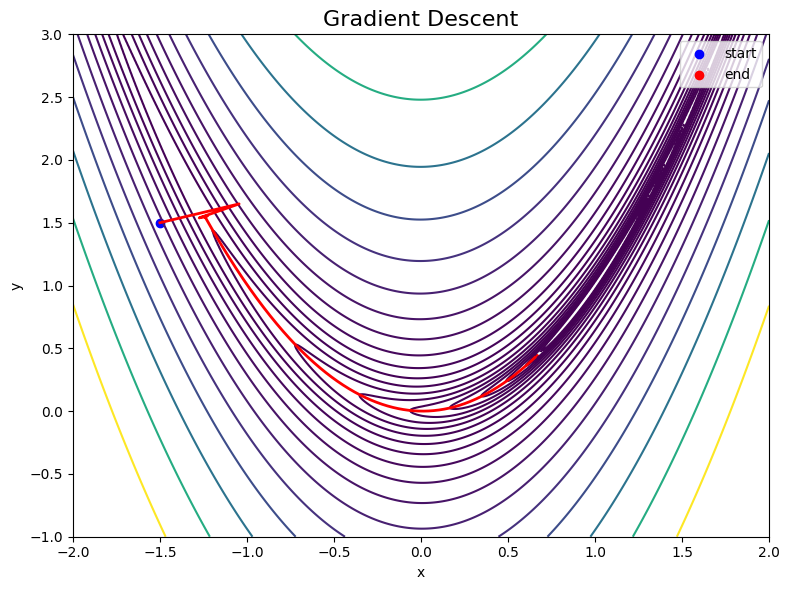

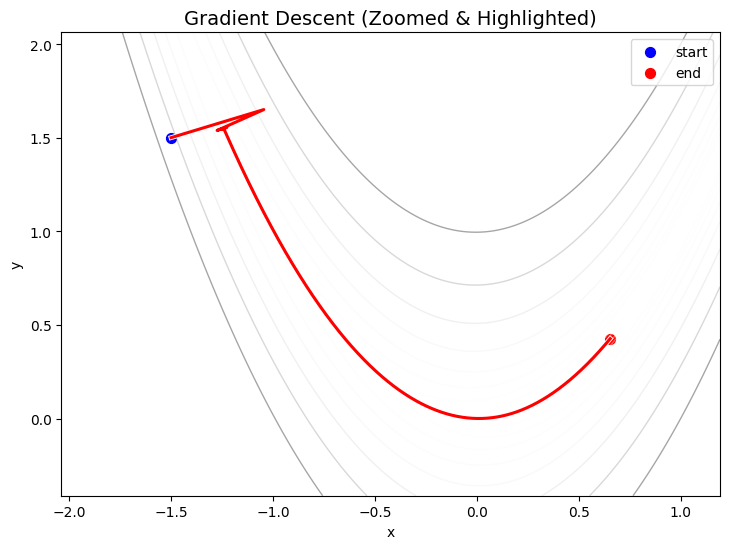

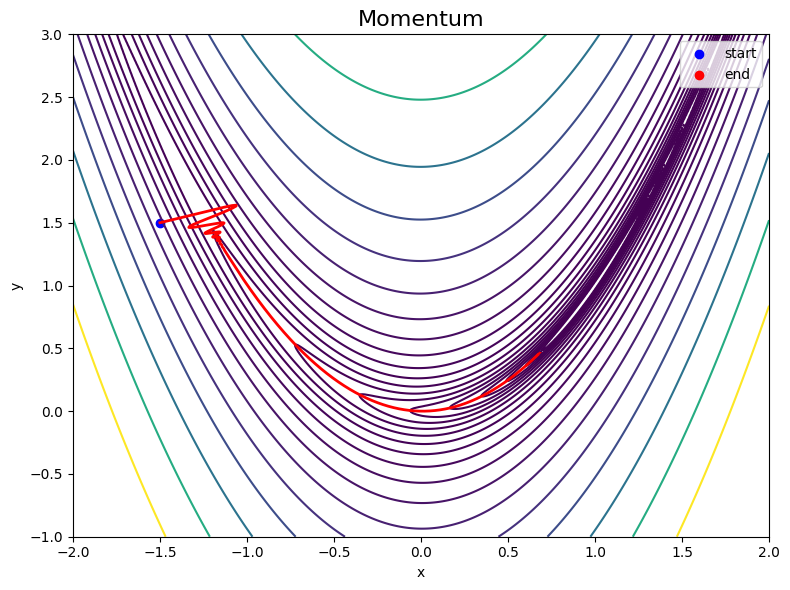

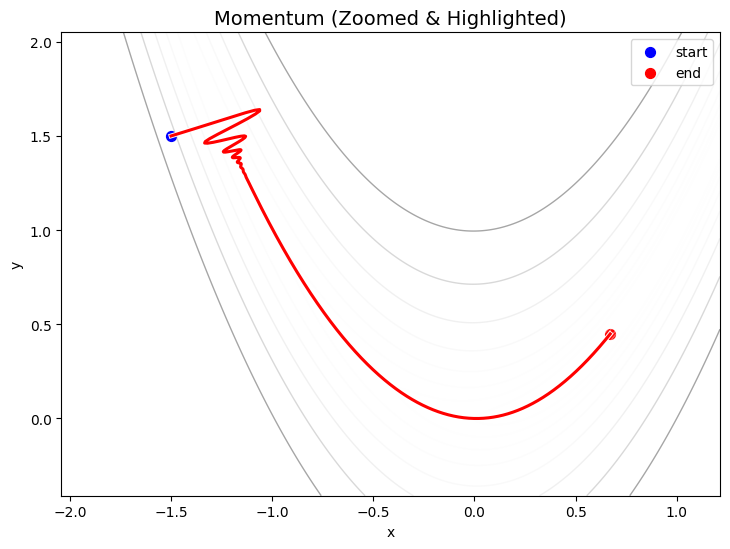

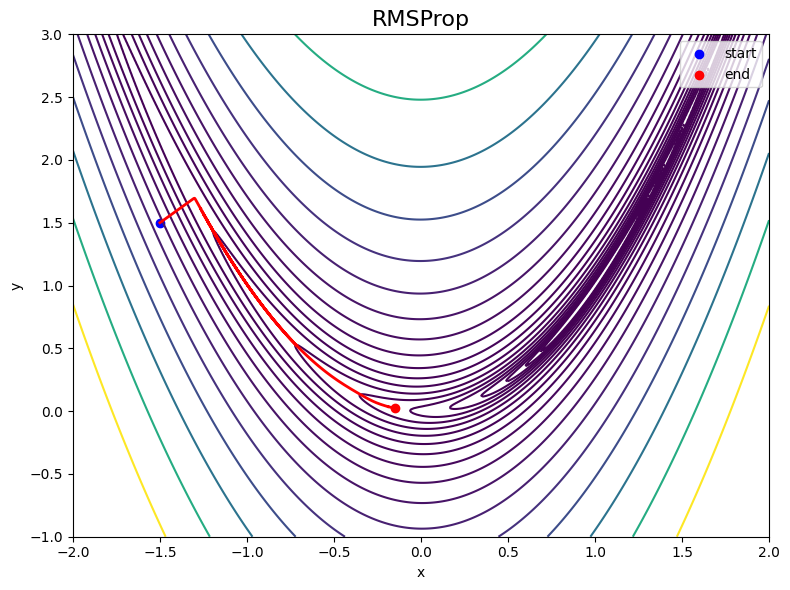

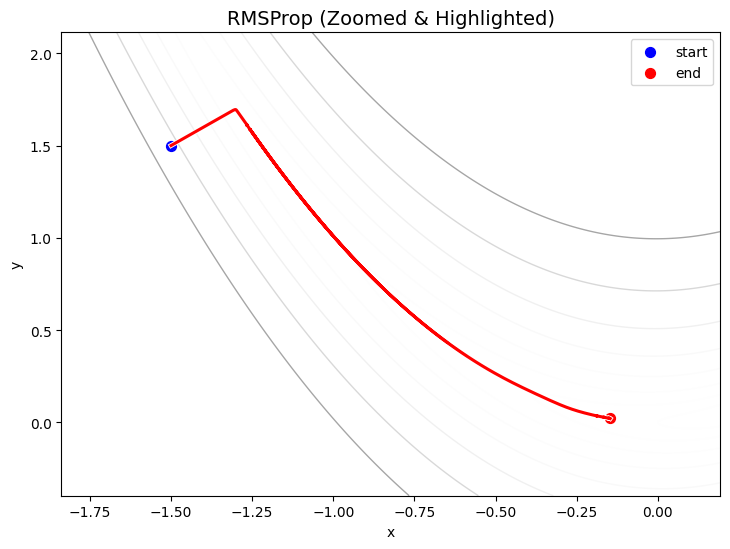

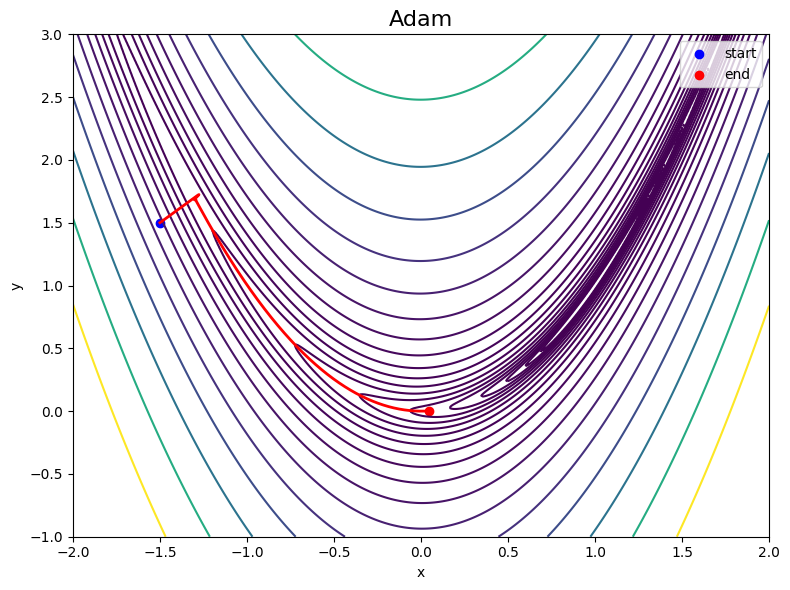

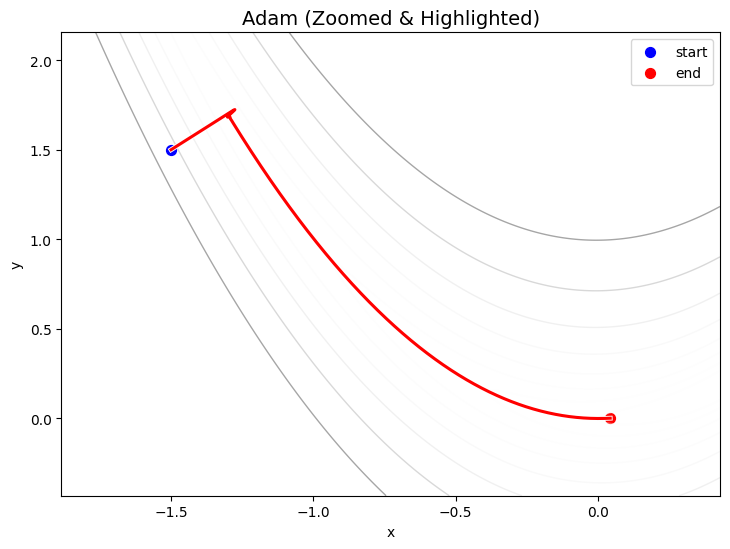

In [ ]:
start = [-1.5, 1.5]

traj_gd = GD(start)
plot_trajectory(traj_gd, "Gradient Descent")
plot_zoomed_trajectory(traj_gd, "Gradient Descent", zoom=0.25)


traj_m = Momentum(start)
plot_trajectory(traj_m, "Momentum")
plot_zoomed_trajectory(traj_m, "Momentum", zoom=0.25)


traj_r = RMSProp(start)
plot_trajectory(traj_r, "RMSProp")
plot_zoomed_trajectory(traj_r, "RMSProp", zoom=0.25)


traj_a = Adam(start, lr=0.01)
plot_trajectory(traj_a, "Adam")
plot_zoomed_trajectory(traj_a, "Adam", zoom=0.25)



In [ ]:
def Nesterov(xy0, lr=0.001, beta=0.9, steps=2000):
    xy = np.array(xy0, dtype=float)
    v = np.zeros_like(xy)
    traj = [xy.copy()]

    for _ in range(steps):
        # Lookahead point
        lookahead = xy - beta * v

        # Gradient at lookahead
        g = grad_f(*lookahead)

        # Update velocity
        v = beta * v + lr * g

        # Update position
        xy = xy - v

        traj.append(xy.copy())

    return np.array(traj)


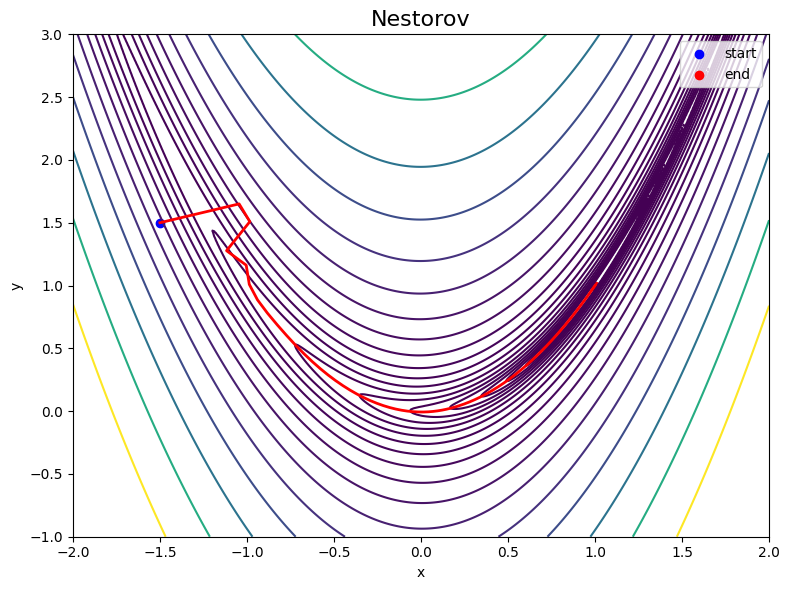

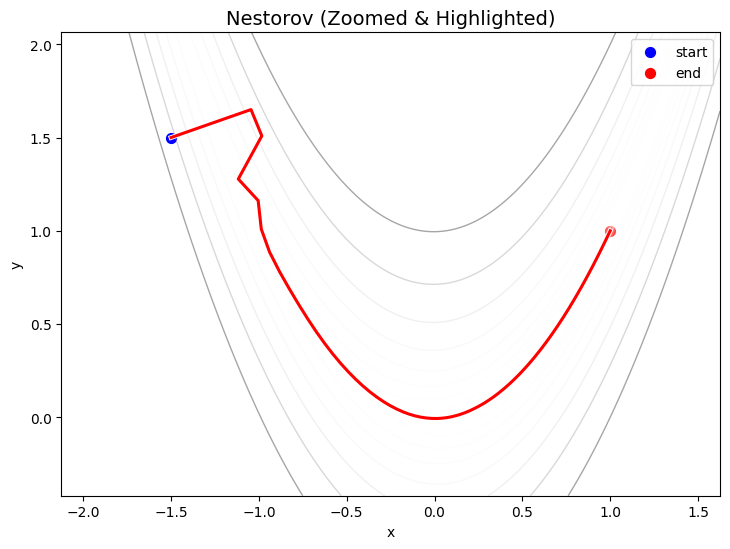

In [ ]:
traj_n = Nesterov(start)
plot_trajectory(traj_n, "Nestorov")
plot_zoomed_trajectory(traj_n, "Nestorov", zoom=0.25)